Connecting google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pwd

'/content/drive/My Drive/Academics/Sem6/IP-project-2022'

In [ ]:
cd /content/drive/MyDrive/Academics/Sem6/IP-project-2022/

/content/drive/MyDrive/Academics/Sem6/IP-project-2022


Importing necessary libraries

In [ ]:
from imutils import contours
from skimage import measure
import numpy as np
import argparse
import imutils
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Applying different thresholds on grayscale image

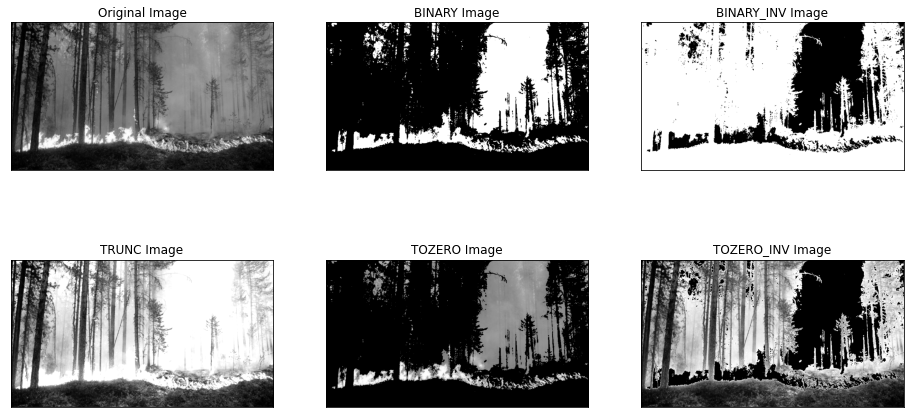

In [ ]:
image = cv2.imread('img1.jpg',0) #0 is to read image as grayscale image
ret,thres1 = cv2.threshold(image,127,255,cv2.THRESH_BINARY)
ret,thres2 = cv2.threshold(image,127,255,cv2.THRESH_BINARY_INV)
ret,thres3 = cv2.threshold(image,127,255,cv2.THRESH_TRUNC)
ret,thres4 = cv2.threshold(image,127,255,cv2.THRESH_TOZERO)
ret,thres5 = cv2.threshold(image,127,255,cv2.THRESH_TOZERO_INV)

titles = ['Original Image','BINARY Image','BINARY_INV Image','TRUNC Image','TOZERO Image','TOZERO_INV Image']
images = [image, thres1, thres2, thres3, thres4, thres5]
plt.figure(figsize=(16,8))
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

Converting to HSV image

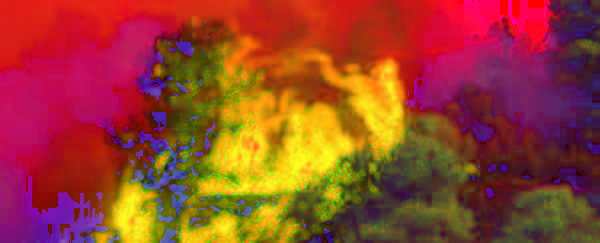

In [ ]:
img = cv2.imread("img3.jpg")
hsvimg=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
cv2_imshow(hsvimg)

Normalizing HSV image and then applying threshold

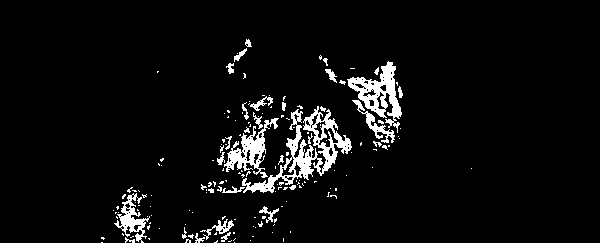

In [ ]:
hsvimg = hsvimg/255
hsvthres = cv2.inRange(hsvimg, (0.02, 0.20, 0.98), (0.30, 1.00, 1.00))
cv2_imshow(hsvthres)

Converting rbg to get YCrCb color space

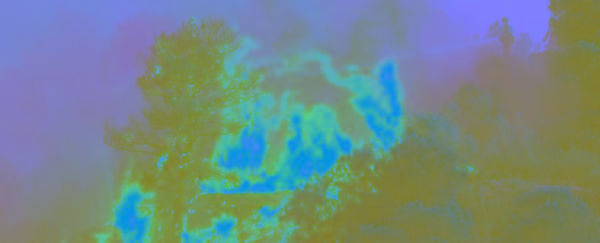

In [ ]:
ycrcbimg=cv2.cvtColor(img,cv2.COLOR_BGR2YCR_CB)
cv2_imshow(ycrcbimg)

Applying thresholding on YCrCb image

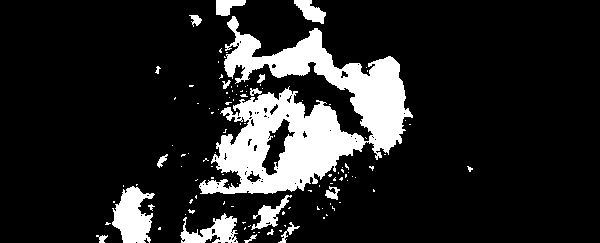

In [ ]:
y, cr, cb = ycrcbimg[:,:,0], ycrcbimg[:,:,1], ycrcbimg[:,:,2] 
ymean = np.float(np.mean(y))
crmean = np.float(np.mean(cr))
cbmean = np.float(np.mean(cb))
ymax = np.float(np.max(y))
crmax = np.float(np.max(cr))
cbmax = np.float(np.max(cb))
ycrcbthres =  cv2.inRange(ycrcbimg.astype(np.float32), (ymean, crmean, 0),(ymax,crmax,cbmean))
cv2_imshow(ycrcbthres)

To get the region containing fire we take intersection of hsv threshold and ycrcb threshold

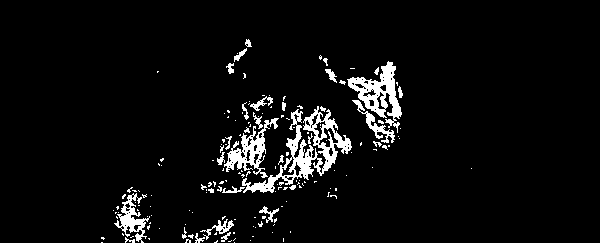

In [ ]:
thresh = cv2.bitwise_and(ycrcbthres,hsvthres)
cv2_imshow(thresh)

Dilate the above image with structuring element of 3X3 matrix of 1s, 4 times to increase the size of fire patches in the image

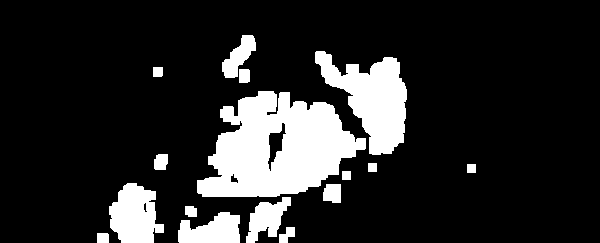

In [ ]:
thresh = cv2.dilate(thresh, None, iterations=4)
cv2_imshow(thresh)

Generating mask to extract fire regions

In [ ]:
labels = measure.label(thresh, connectivity = 2, background=0) #labels the image with 8 connectvity with background labeled as 0
mask = np.zeros(thresh.shape, dtype="uint8")#create a mask of same size as image
for label in np.unique(labels):
  if label == 0: 
    continue #ignore the background

  labelMask = np.zeros(thresh.shape, dtype="uint8")
  labelMask[labels == label] = 255                   
  numPixels = cv2.countNonZero(labelMask)

  if numPixels > 200:
    mask = cv2.add(mask, labelMask)

Find contours (boundaries of a shape with the same intensity) using chain_approx_simple approximation

In [ ]:
cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
if(len(cnts)==0):
  print("No fire detected")

Draw circle on each fire region and label them

In [ ]:
cnts = contours.sort_contours(cnts)[0]
for (i, c) in enumerate(cnts):
	(x, y, w, h) = cv2.boundingRect(c)
	((cX, cY), radius) = cv2.minEnclosingCircle(c)
	cv2.circle(img, (int(cX), int(cY)), int(radius),(0, 0, 255), 3)
	cv2.putText(img, "#{}".format(i + 1), (x, y - 15),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

Final Output containg red circle around fire regions

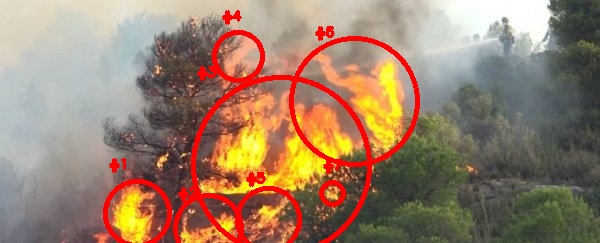

In [ ]:
cv2_imshow(img)